<a href="https://colab.research.google.com/github/joshualewin6/Colab-Notebook/blob/main/unit8exercisessf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit 8 Exercises: The Art of BART

These exercises are grouped into two parts:

- Questions on the nature of decision trees, random forests, and BART models
- An oppurtunity to practice implementing and analyzing a BART model.

Enjoy!

In [1]:
!pip install pymc-bart
!pip install preliz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.1/519.1 kB 13.3 MB/s eta 0:00:00


In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc_bart as pmb
import preliz as pz
import seaborn as sns

## Bartian Theory

**Task1**:

Draw a decision tree--on a physical piece of paper--that predicts how much time you'll spend studying on a given day, using the amount of sleep you got the night before as a predictor.

If this seems to easy, then add another variable or two (test tomorrow? activity after school?), and/or increase the depth of your tree.

You do not have to show me or turn in your tree to earn credit for this question, although I would like to see your drawing.

**Task2**:

What is a decision tree? How do they work?
Each node asks a question about all the data points in that node. For instance, was sleep>7? The yes data points move to one child node, the no's move to the other, and this process continues for more questions, depending on depth and how many data points remain.

**Task3**:

What does the "depth" of a decision tree mean?

It means: how many edges on the tree may a data point cross before the model cuts it off and calls it a group?

How do I know if a tree is too deep, or not deep enough?

If it's not deep enough, the model will be pretty clearly underfitting, and if it's too deep, it overfits.

**Task4:**

How are BART models similar and different from a decision tree?

BART models create decision trees through an MCMC to combine their patterns and combine them for an optimal model, far more complex than a sigular decision tree, but ultimately implements the same choosing principles.

**Task5**:

Why would we use a BART model instead of a decision tree?
A single decision tree could almost never make a reasonable model, considering it exclusively consists of flat lines. A posterior distribution of trees will get much better results.

## Bartian Penguins

**Task6**:

Create a BART model that uses flipper length, bill depth, and bill length to predict body mass in penguins, and make a ppc to check its fit

Code for loading the data is below. You'll need to do everything else yourself.

Remember to use my notes as a reference, and to copy and paste from them when it makes sense to.

Oh, and try a normal likelihood.

In [4]:
#drop the incomplete rows from the data
url="https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/penguins.csv"
penguins = pd.read_csv(url).dropna()
penguins

,species,island,bill_length,bill_depth,flipper_length,body_mass,sex,year
0,Adelie,Torgersen,3.91,1.87,18.1,3.750,male,2007
1,Adelie,Torgersen,3.95,1.74,18.6,3.800,female,2007
2,Adelie,Torgersen,4.03,1.80,19.5,3.250,female,2007
4,Adelie,Torgersen,3.67,1.93,19.3,3.450,female,2007
5,Adelie,Torgersen,3.93,2.06,19.0,3.650,male,2007
...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,5.58,1.98,20.7,4.000,male,2009
340,Chinstrap,Dream,4.35,1.81,20.2,3.400,female,2009
341,Chinstrap,Dream,4.96,1.82,19.3,3.775,male,2009
342,Chinstrap,Dream,5.08,1.90,21.0,4.100,male,2009


(array([ 3., 20., 51., 77., 44., 15., 42., 38., 28., 15.]),
 array([17.2 , 17.79, 18.38, 18.97, 19.56, 20.15, 20.74, 21.33, 21.92,
        22.51, 23.1 ]),
 <BarContainer object of 10 artists>)

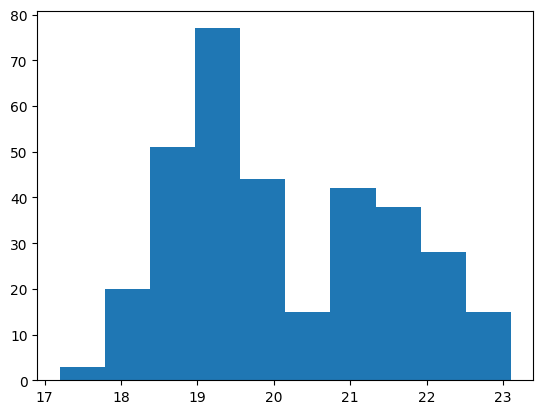

In [5]:
plt.hist(penguins.flipper_length)

(array([ 8., 39., 55., 47., 47., 53., 61., 16.,  5.,  2.]),
 array([3.21 , 3.485, 3.76 , 4.035, 4.31 , 4.585, 4.86 , 5.135, 5.41 ,
        5.685, 5.96 ]),
 <BarContainer object of 10 artists>)

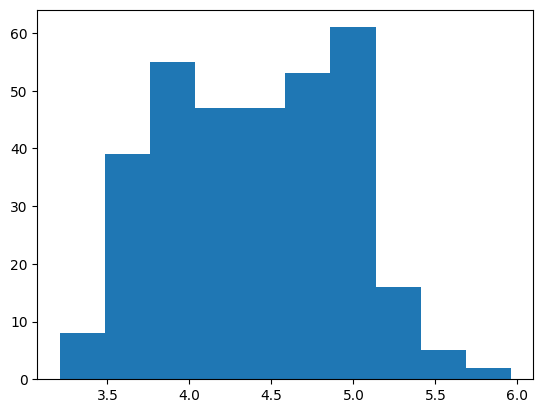

In [6]:
plt.hist(penguins.bill_length)

(array([20., 33., 32., 33., 43., 53., 55., 39., 15., 10.]),
 array([1.31 , 1.394, 1.478, 1.562, 1.646, 1.73 , 1.814, 1.898, 1.982,
        2.066, 2.15 ]),
 <BarContainer object of 10 artists>)

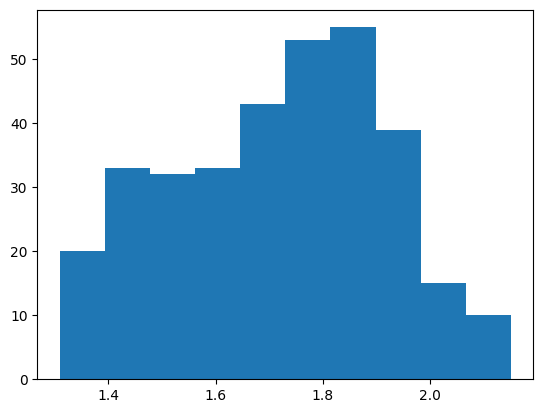

In [7]:
plt.hist(penguins.bill_depth)

(array([14., 42., 69., 52., 41., 39., 27., 27., 16.,  6.]),
 array([2.7 , 3.06, 3.42, 3.78, 4.14, 4.5 , 4.86, 5.22, 5.58, 5.94, 6.3 ]),
 <BarContainer object of 10 artists>)

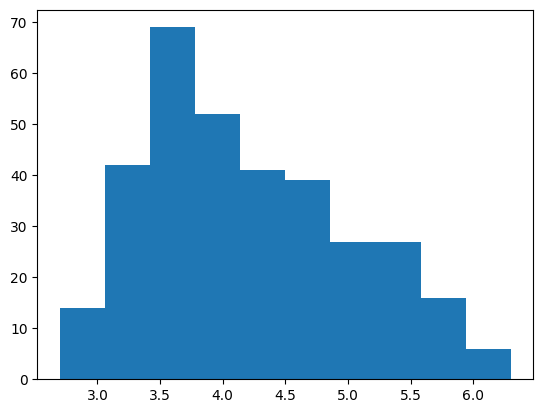

In [8]:
plt.hist(penguins.body_mass)

In [11]:
X_fl = penguins["flipper_length"].to_numpy().reshape(-1,1)
X_bl = penguins["bill_length"].to_numpy().reshape(-1,1)
X_bd = penguins["bill_depth"].to_numpy().reshape(-1,1)
Y = penguins["body_mass"].to_numpy()

In [12]:
with pm.Model() as model_p:
    s = pm.HalfNormal('s',1.2)
    μ_fl = pmb.BART("μ_fl", X_fl, Y, m=50)
    μ_bl = pmb.BART("μ_bl", X_bl, Y, m=50)
    μ_bd = pmb.BART("μ_bd", X_bd, Y, m=50)
    μ = pm.Deterministic("μ",μ_fl+μ_bl+μ_bd)
    y = pm.Normal("y", mu=μ, sigma=s,  observed=Y)
    idata_p = pm.sample(compute_convergence_checks=False)

TypeError: PGBART.__init__() got an unexpected keyword argument 'blocked'

**Task7**:

Plot flipper length versus body mass,

and then plot the posterior predictve from the model over the data.
You're going to copy paste the plotting code from the notes, fyi.

**Task8**:

Interpret the plot above in context. Do you think it captures the true association between flipper length and body mass in penguins? Why or why not? Make sure to reference specific things you see in the plot.

**Task9**:

Create partial depnedence plots (pdps), individual conditional expectation (ice) plots, and a variable importance plot for the BARTpenguin model.

**Task10**:

Using the above plots, make an argument about which variable(s) is/are most important in predicting body mass in penguins.

What is the relationship for each variable to body mass, when you take the other variables into account?

Is that relationship complicated by interactions between variables? How do you know?

Make sure to reference specific things you see in each plot, to justify your decisions and comments.